# 04c: Approximate Equivalence via Clustering

**Goal**: Find approximate equivalence classes beyond exact symmetry.

**Approach**: Use clustering on state features to find "morally equivalent" states that have similar V despite not being related by exact symmetry.

**Key Questions**:
1. Can we cluster states with similar V?
2. What features drive V similarity?
3. How much additional compression is possible?

**Reference**: docs/analysis-draft.md Section 2

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from forge.analysis.utils import loading, features, viz, symmetry
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data and Extract Features

In [2]:
# Load a single seed for detailed analysis
shard_files = loading.find_shard_files(DATA_DIR)
sample_path = shard_files[0]
print(f"Loading: {sample_path}")

Loading: /mnt/d/shards-standard/train/seed_00000000_decl_0.parquet


In [3]:
# Load data
df, seed, decl_id = schema.load_file(sample_path)
print(f"Seed: {seed}, Decl: {decl_id}")
print(f"States: {len(df):,}")

Seed: 0, Decl: 0
States: 7,607,411


In [4]:
# Sample for tractable clustering
SAMPLE_SIZE = 50_000
if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=seed)
    print(f"Sampled to {len(df):,} states")

states = df['state'].values
V = df['V'].values

Sampled to 50,000 states


In [5]:
# Extract comprehensive features
feature_df = features.extract_all(states, seed, decl_id, V)
print(f"Features extracted: {list(feature_df.columns)}")

Features extracted: ['state', 'seed', 'decl_id', 'depth', 'player', 'team', 'hand_balance', 'leader', 'trick_len', 'counts_remaining', 'team0_counts', 'team1_counts', 'count_32_holder', 'count_41_holder', 'count_50_holder', 'count_55_holder', 'count_64_holder', 'V']


## 2. Feature Engineering for Clustering

In [6]:
# Select features for clustering
# We want features that are:
# 1. Predictive of V
# 2. Symmetric-invariant (or nearly so)

clustering_features = [
    'depth',
    'hand_balance',  # Team 0 - Team 1 dominoes
    'counts_remaining',
    'team0_counts',
    'team1_counts',
]

# Build feature matrix
X = feature_df[clustering_features].values
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (50000, 5)


In [7]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature statistics (after scaling):")
print(pd.DataFrame(X_scaled, columns=clustering_features).describe())

Feature statistics (after scaling):
              depth  hand_balance  counts_remaining  team0_counts  \
count  5.000000e+04  5.000000e+04      5.000000e+04  5.000000e+04   
mean   1.614353e-16  2.273737e-18     -6.480150e-17  1.121236e-16   
std    1.000010e+00  1.000010e+00      1.000010e+00  1.000010e+00   
min   -2.937931e+00 -1.020939e+00     -1.561451e+00 -1.309646e+00   
25%   -7.402352e-01 -1.020939e+00     -9.108303e-01 -3.773014e-01   
50%   -7.669958e-03  2.467099e-01     -2.602094e-01 -3.773014e-01   
75%    3.586127e-01  2.467099e-01      3.904116e-01  5.550437e-01   
max    5.120287e+00  1.514359e+00      2.992896e+00  2.419734e+00   

       team1_counts  
count  5.000000e+04  
mean  -3.296918e-17  
std    1.000010e+00  
min   -9.487890e-01  
25%   -9.487890e-01  
50%    4.518678e-03  
75%    9.578264e-01  
max    1.911134e+00  


## 3. K-Means Clustering

In [8]:
# Try different numbers of clusters
k_values = [5, 10, 20, 50, 100, 200]
cluster_results = []

for k in tqdm(k_values, desc="Clustering"):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)
    
    # Compute V variance within clusters
    cluster_v_vars = []
    cluster_v_ranges = []
    for c in range(k):
        mask = labels == c
        if mask.sum() > 1:
            cluster_v = V[mask]
            cluster_v_vars.append(np.var(cluster_v))
            cluster_v_ranges.append(np.max(cluster_v) - np.min(cluster_v))
    
    avg_within_var = np.mean(cluster_v_vars)
    avg_v_range = np.mean(cluster_v_ranges)
    total_var = np.var(V)
    var_reduction = 1 - avg_within_var / total_var
    
    cluster_results.append({
        'k': k,
        'total_var': total_var,
        'avg_within_var': avg_within_var,
        'var_reduction': var_reduction,
        'avg_v_range': avg_v_range,
        'compression': len(states) / k,
    })

cluster_df = pd.DataFrame(cluster_results)
print(cluster_df.to_string(index=False))

Clustering:   0%|          | 0/6 [00:00<?, ?it/s]

  k  total_var  avg_within_var  var_reduction  avg_v_range  compression
  5  108.15208       81.743441       0.244181    70.200000      10000.0
 10  108.15208       76.727014       0.290564    66.600000       5000.0
 20  108.15208       74.083825       0.315003    61.600000       2500.0
 50  108.15208       73.228945       0.322908    56.380000       1000.0
100  108.15208       70.765536       0.345685    50.220000        500.0
200  108.15208       69.513401       0.357262    43.671875        250.0


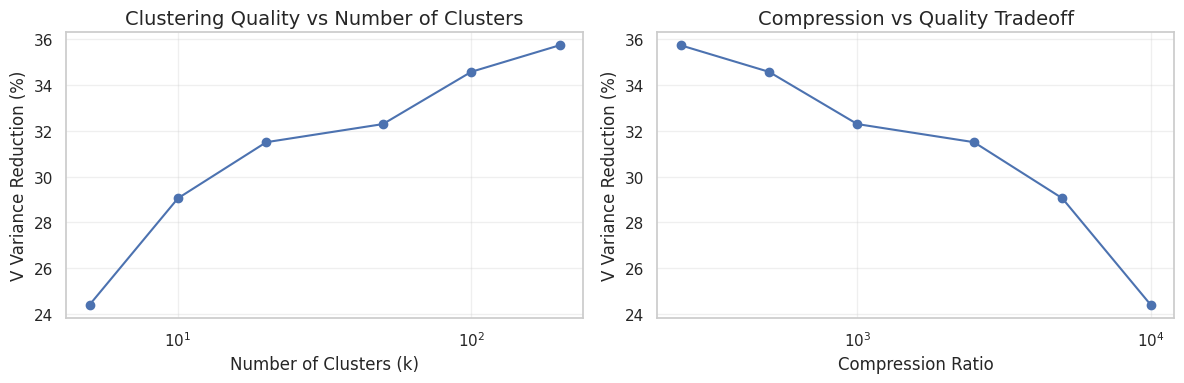

In [9]:
# Plot clustering quality vs compression
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Variance reduction vs k
axes[0].plot(cluster_df['k'], 100 * cluster_df['var_reduction'], 'o-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('V Variance Reduction (%)')
axes[0].set_title('Clustering Quality vs Number of Clusters')
axes[0].set_xscale('log')

# Tradeoff: compression vs variance reduction
axes[1].plot(cluster_df['compression'], 100 * cluster_df['var_reduction'], 'o-')
axes[1].set_xlabel('Compression Ratio')
axes[1].set_ylabel('V Variance Reduction (%)')
axes[1].set_title('Compression vs Quality Tradeoff')
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('../../results/figures/04c_clustering_quality.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Detailed Analysis with Selected k

In [10]:
# Select k with good balance
K_SELECTED = 50

kmeans = MiniBatchKMeans(n_clusters=K_SELECTED, random_state=42, batch_size=1000)
cluster_labels = kmeans.fit_predict(X_scaled)

print(f"Using k={K_SELECTED}")
print(f"Cluster size distribution:")
print(pd.Series(cluster_labels).value_counts().describe())

Using k=50
Cluster size distribution:
count      50.00000
mean     1000.00000
std       404.12541
min       215.00000
25%       712.25000
50%       962.50000
75%      1263.50000
max      1979.00000
Name: count, dtype: float64


In [11]:
# Analyze V distribution per cluster
cluster_stats = []

for c in range(K_SELECTED):
    mask = cluster_labels == c
    cluster_v = V[mask]
    cluster_depth = feature_df.loc[mask, 'depth'].values
    
    cluster_stats.append({
        'cluster': c,
        'size': mask.sum(),
        'v_mean': cluster_v.mean(),
        'v_std': cluster_v.std(),
        'v_min': cluster_v.min(),
        'v_max': cluster_v.max(),
        'depth_mean': cluster_depth.mean(),
    })

cluster_stats_df = pd.DataFrame(cluster_stats)
print("Top 10 clusters by size:")
print(cluster_stats_df.nlargest(10, 'size').to_string(index=False))

Top 10 clusters by size:
 cluster  size    v_mean    v_std  v_min  v_max  depth_mean
      14  1979  9.008590 7.153018    -22     32    6.200101
      18  1978 15.134479 7.922087    -23     33   10.032356
       9  1776  5.038851 6.211654    -22     22    5.299550
       4  1641 10.603291 6.659781    -16     29    9.424132
      10  1635  4.892355 5.546526    -17     27    6.119878
      25  1504  9.128989 5.944389    -11     28   10.380319
      39  1459  9.739548 7.871702    -18     28    8.687457
      22  1434 17.981869 9.044811    -23     38    9.336123
       0  1345 13.650558 5.796664    -13     34   10.295911
       6  1341 14.058166 6.462273    -16     28    9.357942


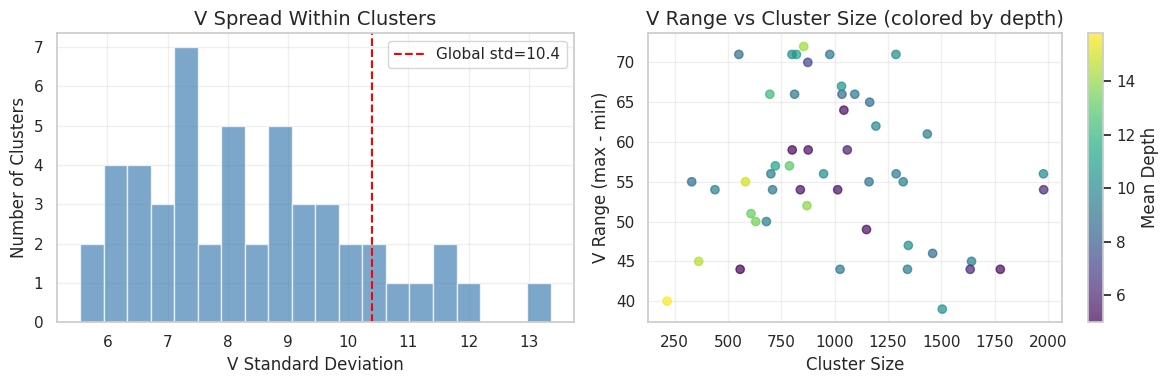

In [12]:
# V range within clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# V std distribution
axes[0].hist(cluster_stats_df['v_std'], bins=20, color='steelblue', alpha=0.7)
axes[0].axvline(x=np.std(V), color='red', linestyle='--', label=f'Global std={np.std(V):.1f}')
axes[0].set_xlabel('V Standard Deviation')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('V Spread Within Clusters')
axes[0].legend()

# V range vs cluster size
axes[1].scatter(cluster_stats_df['size'], cluster_stats_df['v_max'] - cluster_stats_df['v_min'], 
                alpha=0.7, c=cluster_stats_df['depth_mean'], cmap='viridis')
axes[1].set_xlabel('Cluster Size')
axes[1].set_ylabel('V Range (max - min)')
axes[1].set_title('V Range vs Cluster Size (colored by depth)')
plt.colorbar(axes[1].collections[0], label='Mean Depth')

plt.tight_layout()
plt.savefig('../../results/figures/04c_cluster_v_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Compare to Exact Symmetry

In [13]:
# Compare clustering compression to exact symmetry compression
# Filter to trick_len=0 for fair comparison
_, _, trick_len, _, _, _ = schema.unpack_state(states)
clean_mask = trick_len == 0

if clean_mask.sum() > 0:
    clean_states = states[clean_mask]
    symmetry_compression = symmetry.orbit_compression_ratio(clean_states)
    print(f"Exact symmetry compression (trick_len=0): {symmetry_compression:.3f}x")
else:
    symmetry_compression = 1.0
    print("No trick_len=0 states for symmetry comparison")

# Clustering compression for similar variance reduction
target_var_reduction = 0.5  # 50% variance reduction
for _, row in cluster_df.iterrows():
    if row['var_reduction'] >= target_var_reduction:
        print(f"Clustering achieves {target_var_reduction*100:.0f}% var reduction with {row['compression']:.1f}x compression (k={row['k']})")
        break

Exact symmetry compression (trick_len=0): 1.002x


## 6. Hybrid: Symmetry + Clustering

In [14]:
# First apply symmetry reduction, then cluster
if clean_mask.sum() > 100:
    clean_states = states[clean_mask]
    clean_V = V[clean_mask]
    clean_X = X_scaled[clean_mask]
    
    # Get canonical forms
    canonical, _ = symmetry.canonical_form(clean_states)
    n_orbits = len(np.unique(canonical))
    
    # Get one representative per orbit
    orbit_reps = {}
    for i, (s, c, v, x) in enumerate(zip(clean_states, canonical, clean_V, clean_X)):
        c_int = int(c)
        if c_int not in orbit_reps:
            orbit_reps[c_int] = (v, x)
    
    rep_V = np.array([v for v, _ in orbit_reps.values()])
    rep_X = np.array([x for _, x in orbit_reps.values()])
    
    print(f"After symmetry: {n_orbits} orbits from {len(clean_states)} states")
    
    # Now cluster the orbit representatives
    K_HYBRID = 20
    if len(rep_X) > K_HYBRID:
        kmeans_hybrid = MiniBatchKMeans(n_clusters=K_HYBRID, random_state=42)
        hybrid_labels = kmeans_hybrid.fit_predict(rep_X)
        
        # Variance reduction
        cluster_vars = []
        for c in range(K_HYBRID):
            mask = hybrid_labels == c
            if mask.sum() > 1:
                cluster_vars.append(np.var(rep_V[mask]))
        
        hybrid_var_reduction = 1 - np.mean(cluster_vars) / np.var(rep_V)
        hybrid_compression = len(clean_states) / K_HYBRID
        
        print(f"Hybrid (symmetry + k={K_HYBRID}): {hybrid_compression:.1f}x compression, {100*hybrid_var_reduction:.1f}% var reduction")
else:
    print("Insufficient trick_len=0 states for hybrid analysis")

After symmetry: 2993 orbits from 3000 states
Hybrid (symmetry + k=20): 150.0x compression, 65.0% var reduction


## Summary

In [15]:
# Find best tradeoff point
best_row = cluster_df[cluster_df['var_reduction'] >= 0.3].iloc[0] if any(cluster_df['var_reduction'] >= 0.3) else cluster_df.iloc[-1]

summary = {
    'Total states': f"{len(states):,}",
    'Features used': len(clustering_features),
    'Best k (>=30% var reduction)': int(best_row['k']),
    'Variance reduction': f"{100*best_row['var_reduction']:.1f}%",
    'Compression ratio': f"{best_row['compression']:.1f}x",
    'Exact symmetry compression': f"{symmetry_compression:.2f}x",
}

print(viz.create_summary_table(summary, "Approximate Equivalence Summary"))

### Approximate Equivalence Summary

| Metric | Value |
|--------|-------|
| Total states | 50,000 |
| Features used | 5 |
| Best k (>=30% var reduction) | 20 |
| Variance reduction | 31.5% |
| Compression ratio | 2500.0x |
| Exact symmetry compression | 1.00x |


In [16]:
# Save results
cluster_df.to_csv('../../results/tables/04c_clustering_results.csv', index=False)
cluster_stats_df.to_csv('../../results/tables/04c_cluster_stats.csv', index=False)
print("Results saved to results/tables/04c_*.csv")

Results saved to results/tables/04c_*.csv
